# The Single Domain Comprehensive Calculator (SDCC).

## Single Domain Energy Surfaces

### `energy` module
The `energy` module is used for low-level energy calculations with SD grains of different parameters. We won't explore these here, but these feed into our energy surface plots

### Input Parameters for Plotting Energy Surfaces

`TMx` is the % titanomagnetite in the composition  
`PRO` is the prolateness of the ellipsoid geometry (major axis/intermediate axis)  
`OBL` is the oblateness of the ellipsoid geometry (intermediate axis/minor axis)  
`alignment` is the direction of the elongation, either `easy` for along an easy axis or `hard` for along a hard axis.  
`T` is the temperature at which the surface is being evaluated (optional)  
`ext_field` is the external field - [theta,phi,intensity (T)] (optional)

In [2]:
TMx = 60
PRO = 1.20 #Prolateness >=1
OBL = 1.00 #Oblateness >=1
alignment = 'hard' #Alignment of easy axis to major axis of ellipsoid
T = 20 # Temperature
ext_field=[0,0,0]

### Plotting Energy Surfaces
Energy surfaces can be plotted using the `plotting` module: particularly the `plot_energy_surface()` function. Dark regions represent energy minima, and light regions represent maxima

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
/opt/anaconda3/lib/python3.11/site-packages/sdcc/plotting.py:200: UserWarning: linewidths is ignored by contourf
  plt.contourf(np.degrees(thetas),np.degrees(phis),energies,


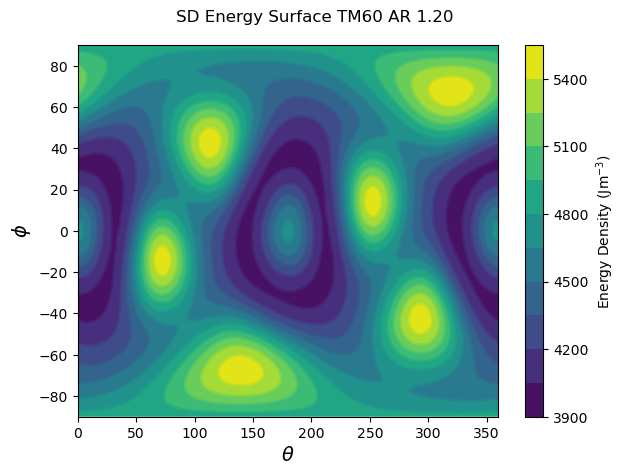

In [3]:
from sdcc.plotting import plot_energy_surface
import matplotlib.pyplot as plt
%matplotlib inline
plot_energy_surface(TMx,alignment,PRO,OBL,T,ext_field)

We can also use a stereonet projection with the argument `projection='stereo'`

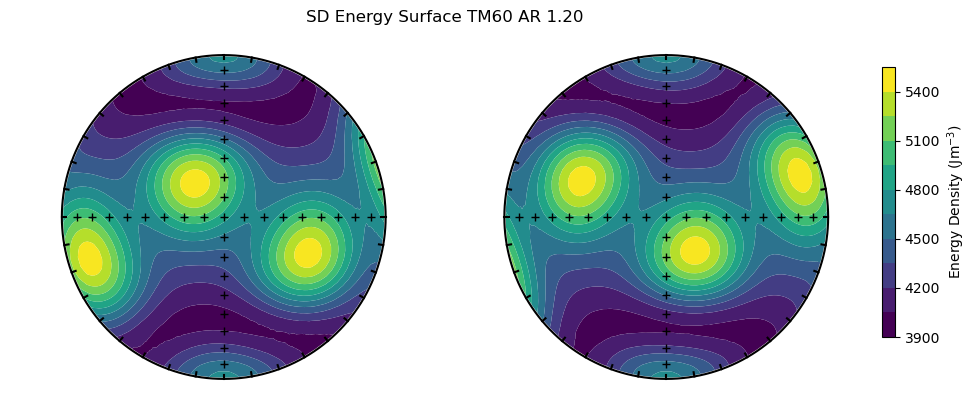

In [61]:
plot_energy_surface(TMx,alignment,PRO,OBL,T,ext_field,projection='stereo')

## Energy Barriers
### Finding energy barriers
Energy barriers are found using a method which sweeps a contour up from the global minimum of the energy map until our global minimum becomes connected to another local minimum - known as the "watershed algorithm".

Energy barriers are found using the `find_all_barriers` function.
This function outputs several things:

`minima_thetas` - Array of LEM state location thetas  
`minima_phis` - Array of LEM state location phis  
`minima_energies` - Energies of each LEM state  
`barrier_thetas` - Matrix of energy barrier location thetas between LEM states  
`barrier_phis` - Matrix of energy barrier location phis between LEM states  
`barrier_energies` - Energies of barriers between LEM states


In [62]:
from sdcc.barriers import find_all_barriers
minima_thetas,minima_phis,minima_energies,\
    barrier_thetas,barrier_phis,barrier_energies \
        = find_all_barriers(TMx,alignment,PRO,OBL,T,ext_field,prune=True)

### Plotting Energy Barriers
The locations of minima and energy barriers can be plotted on top of an energy surface using the `plot_minima()` and `plot_barriers()` functions. Barriers between minima `i` and minima `j` are labelled `i,j`.

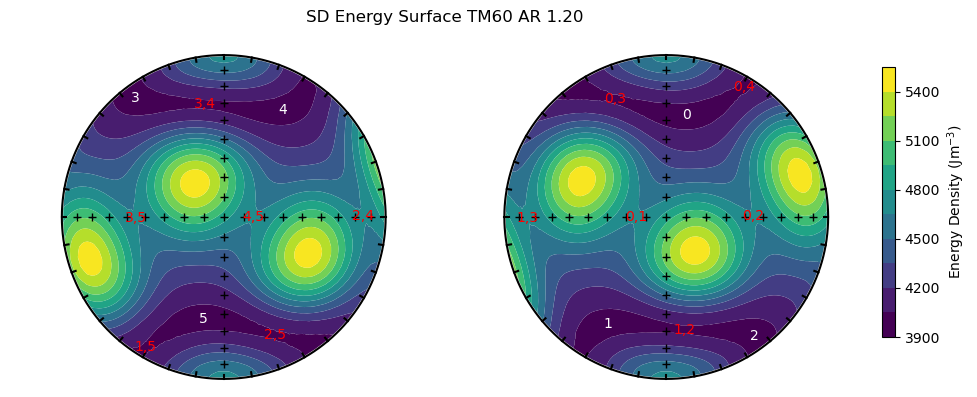

In [63]:
from sdcc.plotting import plot_barriers,plot_minima

plot_energy_surface(TMx,alignment,PRO,OBL,T,ext_field,projection='stereo')
plot_minima(minima_thetas,minima_phis,projection='stereo')
plot_barriers(barrier_thetas,barrier_phis,projection='stereo')
plt.savefig('example_energy_surface.pdf')


Additionally, the height of each barrier can be plotted using the `energy_matrix_plot` function.

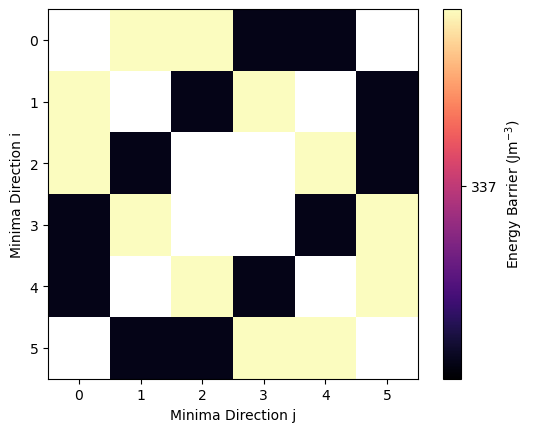

In [75]:
from sdcc.plotting import energy_matrix_plot
energy_matrix_plot(barrier_energies)

### Plotting minimum energy paths

With the parameters supplied at the start, when reading these two plots- we can see that we have two groups of directions in this grain that are easy to move between - with four easy directions in each group. The two groups have a large energy barrier between them. This seems like it will form two easy "cones" of directions. What will the easiest energy paths look like within this cone? We can utilize a gradient descent algorithm initialized near the barriers to obtain a minimum. 
We do this using the `mat_to_mask()` (for legacy purposes) and `plot_energy_path()` functions. As before - we can plot minima and barriers on top if we so wish.  
Note that the gradient descent is slow. The `n_saddles` function changes the number of barriers to start the initialization from. Lowering this can reduce computation time. On my computer this cell takes about 30s to 1 minute to run.
You can also use the flag `method=fast` to approximate the gradient descent.
This is significantly faster, but less accurate. The `n_perturbations` chooses the number of random initializations near each energy barrier, increasing the chances of showing the full path. Computation time scales with `n_saddles * n_perturbations`.

Note that these paths are not actually needed for calculations, but could be a useful visual. Also you might be able to get something similar from contouring the watershed algorithm result applied to the negative of the energy surface.

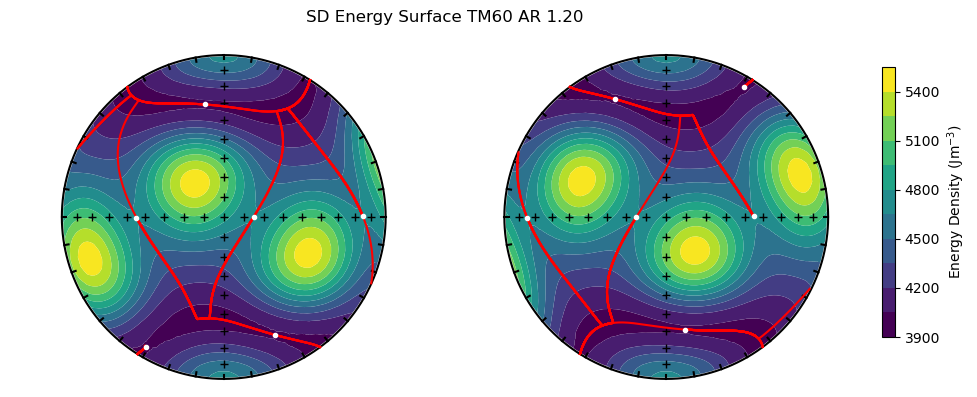

In [7]:
#Don't rerun this unless you change parameters - it's very slow
#Use method='fast' to speed up (at the cost of less accurate paths).
from sdcc.plotting import plot_energy_path
from sdcc.barriers import mat_to_mask
import matplotlib.pyplot as plt
mask=mat_to_mask(barrier_thetas,barrier_phis)
plot_energy_path(TMx,alignment,PRO,OBL,mask,T=T,ext_field=ext_field
,method='slow',n_saddles=16,projection='stereo')

## Barriers as a function of temperature

### The GEL object
The GEL (for Grain Energy Landscape, name can change) object stores energy barriers as a function of temperature. Instead of storing the barriers directly, it creates a set of polynomials which track these barriers through the temperatures.
Note that this could probably be optimized to calculate barriers over a smaller range of temperatures.

In [6]:
from sdcc.barriers import GEL
import pickle
#This may take some time depending on your single-threaded processor speed. 
#It would make sense (and wouldn't be very hard) to do this using multiprocessing. 
gel_test=GEL(TMx,alignment,PRO,OBL)

#Uncomment the two lines below to load an already saved version of the file
#with open('test.gel', 'rb') as f:
    #gel_test=pickle.load(f)

The energy barriers at a particular temperature can be accessed using the GEL object's `get_params()` method. This takes a temperature as the argument and returns a dictionary of directions for the LEM states and barriers between them.

In [7]:
params = gel_test.get_params(20)
print(params)

{'min_dir': array([[ 2.006272366434620e-01, -6.315344191159782e-01],
       [ 3.644433462046099e+00, -4.461605793455110e-01],
       [ 2.500734846825191e+00, -1.634160461825734e-01],
       [ 5.642327500414985e+00,  1.634160461825735e-01],
       [ 5.028408084563057e-01,  4.461605793455110e-01],
       [ 3.342219890233255e+00,  6.315344191159782e-01],
       [ 3.141592653589793e+00,  4.770489558936224e-17],
       [ 0.000000000000000e+00,  4.770489558936224e-17]]), 'min_e': array([4009.2848943105314, 4009.284365056114 , 4009.287060366695 ,
       4009.287060366695 , 4009.2843650561176, 4009.2848943105296,
                      inf,                inf]), 'bar_dir': array([[[ 0.785398163397448,                inf],
        [ 4.70566108781844 , -1.306790686062507],
        [ 1.564513141487717, -0.788539756051039],
        [ 5.874513501111541, -0.379972658718843],
        [ 0.540364372860955, -0.125747680419199],
        [ 0.785398163397448,                inf],
        [ 0.785398163397448

Notice that we have 8, rather than the 6 LEM states we expected here. That's because we go from 6 LEM states to 2 at higher temperature, and these are treated differently.
Because they can take a long time to make, and can be accessed relatively easily, GELs can be saved to file using the `to_file()` method, which takes a file name as the argument.

In [8]:
gel_test.to_file('test.gel')

## Treatment routines
Thermally activated experiments can be run using routines in the `simulations` module. Today we're going to look at the viscous relaxation of a TRM. A set of thermal treatment steps is needed to do this, which can be found in the `treatment` module.

In [9]:
from sdcc.treatment import relaxation_time

In [10]:
B_dir = [1,0,0] #Field direction - along x here
B_str = 40 #Field strength - 40uT
relax_routine = relaxation_time(gel_test, B_dir,B_str)
relax_routine

[Cooling from 163 to 20°C
              in 40 μT field,
 VRM acquisition at 20°C 
             in 0 μT field]

In [7]:
relax_routine[1].field_strs

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

A viscous relaxation is counted as a VRM acquisition but it's the same. More complicated treatment routines also exist, here's an example for a Coe paleointensity experiment. Routines can be constructed using lists of the `treatment.ThermalStep` class.

In [8]:
from sdcc.treatment import coe_experiment
B_anc = 30
B_ancdir = [0,0,1]
temp_steps = [100,200,300,300,400,450,500,520,540,560,580]
coe = coe_experiment(temp_steps,B_anc,B_str,B_ancdir,B_dir)

We can plot the temperature and time of the routine using the `plot_routine` function. Colours represent heating/cooling (purple for hold times) Solid lines are in field and dashed lines are zero field.

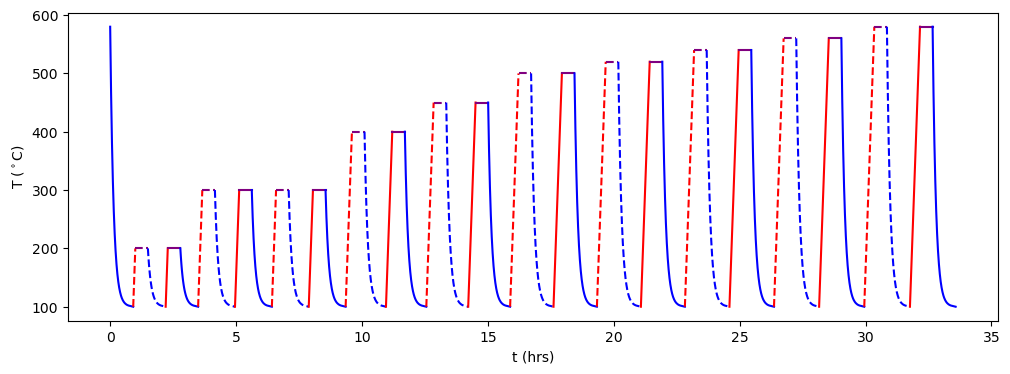

In [9]:
from sdcc.plotting import plot_routine
plot_routine(coe)

Because we only have a GEL file for a single grain, a coe experiment won't tell us much, but we can calculate the relaxation time. We can simulate such an experiment for a mono-dispersion of grains using the `parallelized_mono_dispersion()` function in `simulation`. This returns a set of magnetization vectors (averaged over the sphere) and state vectors (not averaged, one for each direction) which can be used to calculate

In [15]:
from sdcc.simulation import parallelized_mono_dispersion
d = 80 #ESVD of grain
#We have 8 states so this partitions things equally into them at Tc
start_p = [1/8,1/8,1/8,1/8,1/8,1/8,1/8,1/8] 
vs,ps = parallelized_mono_dispersion(start_p, d, relax_routine, gel_test)

There isn't currently a plotting function for these results, but we can plot the results against log time.

In [18]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

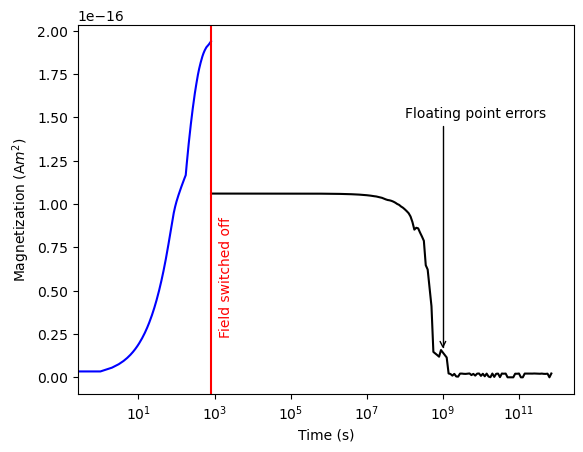

In [64]:
TRM_vectors=vs[0]
TRM_ts=relax_routine[0].ts
relax_vectors=vs[1]
relax_ts=relax_routine[1].ts
fig,ax=plt.subplots()
ax.plot(TRM_ts,np.linalg.norm(TRM_vectors,axis=1),'b')
ax.plot(relax_ts,np.linalg.norm(relax_vectors,axis=1),'k')
ax.axvline(TRM_ts[-1],0,color='r')
ax.text(TRM_ts[-1]+5e2,0.25e-16,'Field switched off',rotation=90,color='r',ha='left')
arrowprops = dict(
    arrowstyle="->",
    connectionstyle="angle,angleA=0,angleB=90,rad=10")
ax.annotate('Floating point errors',xy=(1e9,0.15e-16),xytext=(1e8,1.5e-16),arrowprops=arrowprops)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Magnetization (A$m^2$)')
ax.semilogx();
plt.savefig('Relaxation_Time.pdf')

We can see that the magnetization is lost in the range 1e8 - 1e9 seconds (3 - 30 years) but floating point errors make this calculation tricky. A large proprtion of the magnetization (~40%) is lost instantaneously due to the very small energy barrier between states 1, 3 and 4. There are floating point errors which cause problems when the time difference between two time steps is large (i.e. at longer times, as times here are log spaced). This could potentially be fixed using Les' C implementation? The mpmath implementation here has pade versions, but these are slower and have the same issue.